In [1]:
#pip install tensorflow keras opencv-python

Importing the Modules

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from IPython.display import display, Image
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

DataLoading and Preprocessing

In [3]:
# Define the path to the dataset folders
happy_folder = "/kaggle/input/pets-facial-expression-dataset/happy"
sad_folder = "/kaggle/input/pets-facial-expression-dataset/Sad"
angry_folder = "/kaggle/input/pets-facial-expression-dataset/Angry"


# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (48, 48))  # Resize to a fixed size for the model
            images.append(img)
    return images

# Load images and labels for each emotion
happy_images = load_images_from_folder(happy_folder)
sad_images = load_images_from_folder(sad_folder)
angry_images = load_images_from_folder(angry_folder)


# Create labels for each emotion category
happy_labels = [0] * len(happy_images)
sad_labels = [1] * len(sad_images)
angry_labels = [2] * len(angry_images)


# Concatenate images and labels
X = np.array(happy_images + sad_images + angry_images)
y = np.array(happy_labels + sad_labels + angry_labels)

# Normalize pixel values to range [0, 1]
X = X.astype('float32') / 255.0

# One-hot encode the labels
y = np_utils.to_categorical(y, 3)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training and Evaluation

In [4]:


# Build the CNN model
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

print(model.summary())
# Compile the model with class weights
model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       7

In [5]:

# Calculate class weights
total_samples = len(y_train)
class_weights = {0: total_samples / np.sum(y_train[:, 0]), 
                 1: total_samples / np.sum(y_train[:, 1]), 
                 2: total_samples / np.sum(y_train[:, 2])}
# Train the model with class weights
history = model.fit(X_train.reshape(-1, 48, 48, 1), y_train, batch_size=32, epochs=100, validation_split=0.1, class_weight=class_weights,verbose=0)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test.reshape(-1, 48, 48, 1), y_test)
losstr, accuracytr = model.evaluate(X_train.reshape(-1, 48, 48, 1), y_train)


# Save the trained model
model.save("facial_expression_model.h5")


2023-07-24 17:53:07.268196: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6/6 [==============================] - 0s 7ms/step - loss: 1.5968 - accuracy: 0.6517


In [6]:
print(f"Test accuracy: {accuracy*100:.2f}%")
print(f"Train accuracy: {accuracytr*100:.2f}%")

Test accuracy: 40.00%
Train accuracy: 65.17%


Hyper Parameter tuning

In [7]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# # Function to create and compile the CNN model
def create_cnn_model(conv_filters_1=64, conv_filters_2=128, dense_units=512, dropout_rate=0.5):
 model = Sequential
 model.add(Conv2D(conv_filters_1, (3, 3), activation='relu', input_shape=(48, 48, 1)))
 model.add(Conv2D(conv_filters_1, (3, 3), activation='relu'))
 model.add(MaxPooling2D(pool_size=(2, 2)))
 model.add(Dropout(dropout_rate))

 model.add(Conv2D(conv_filters_2, (3, 3), activation='relu'))
 model.add(Conv2D(conv_filters_2, (3, 3), activation='relu'))
 model.add(MaxPooling2D(pool_size=(2, 2)))
 model.add(Dropout(dropout_rate))

 model.add(Flatten())
 model.add(Dense(dense_units, activation='relu'))
 model.add(Dropout(dropout_rate))
 model.add(Dense(3, activation='softmax'))

#     # Compile the model with categorical_crossentropy loss
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model

# # Create a KerasClassifier wrapper for the CNN model
cnn_model = KerasClassifier(build_fn=create_cnn_model, epochs=10, batch_size=64, verbose=1)

# # Define the hyperparameter space to search
param_grid = {
 'conv_filters_1': [32, 64, 128],
  'conv_filters_2': [64, 128, 256],
  'dense_units': [256, 512, 1024],
  'dropout_rate': [0.25, 0.5, 0.75]
}

# # Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(cnn_model, param_distributions=param_grid, n_iter=10, cv=3, verbose=1, random_state=42)

# # Fit the RandomizedSearchCV to the data
random_search_result = random_search.fit(X_train.reshape(-1, 48, 48, 1), y_train)

# # Print the best hyperparameters found
print("Best Parameters:", random_search_result.best_params_)

# # Retrieve the best model
best_model = random_search_result.best_estimator_

# # Evaluate the best model on test data
loss, accuracy = best_model.model.evaluate(X_test.reshape(-1, 48, 48, 1), y_test)
print(f"Test accuracy of the best model: {accuracy*100:.2f}%")


#Testing the model

1/1 [==============================] - 0s 343ms/step
Predicted Emotion: angry
Confidence [happy, sad, angry]: [2.4067668e-07 2.3604160e-07 9.9999952e-01]


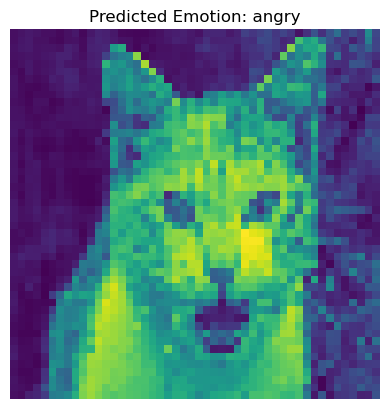

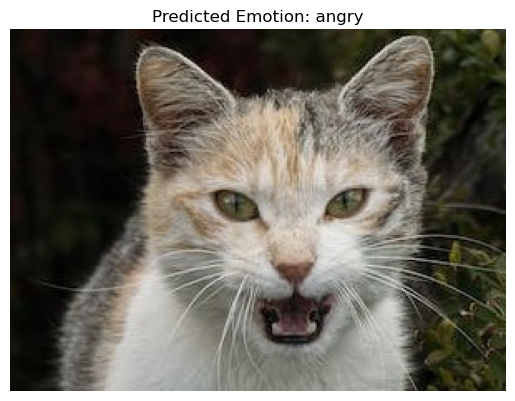

In [8]:
from keras.models import load_model
# Load the saved model
loaded_model = load_model("facial_expression_model.h5")



# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (48, 48))  # Resize to a fixed size for the model
            images.append(img)
    return images


# Load a custom test image
custom_test_image_path = "/kaggle/input/pets-facial-expression-dataset/Angry/16924834.jpg"

custom_test_image = cv2.imread(custom_test_image_path)
custom_test_image = cv2.cvtColor(custom_test_image, cv2.COLOR_BGR2GRAY)
custom_test_image = cv2.resize(custom_test_image, (48, 48))
custom_test_image = custom_test_image.astype('float32') / 255.0

# Reshape the image to match the model input shape
custom_test_image = np.expand_dims(custom_test_image, axis=0)
custom_test_image = np.expand_dims(custom_test_image, axis=-1)

# Make predictions on the custom test image
prediction = loaded_model.predict(custom_test_image)
prediction_prob = prediction[0]

emotion_label = np.argmax(prediction[0])

# Map the predicted label to emotion class
emotion_classes = {0: 'happy', 1: 'sad', 2: 'angry'}
predicted_emotion = emotion_classes[emotion_label]

# Print the custom test image and its predicted label
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence [happy, sad, angry]: {prediction_prob}")

import matplotlib.pyplot as plt

#Display the custom test image using matplotlib
plt.imshow(custom_test_image[0, :, :, 0])
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

from PIL import Image
# Display the original custom test image using PIL
img_pil = Image.open(custom_test_image_path)
plt.imshow(np.array(img_pil))
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()



1/1 [==============================] - 0s 139ms/step
Predicted Emotion: happy
Confidence [happy, sad, angry]: [0.8207702  0.00153343 0.17769638]


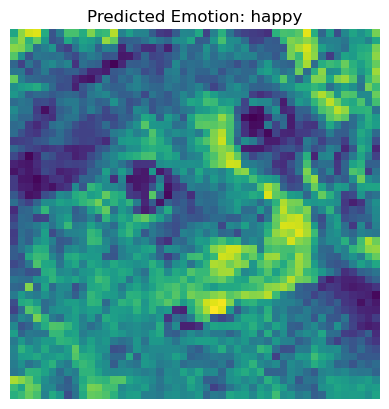

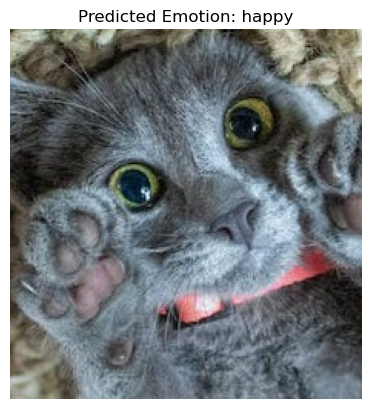

In [9]:
from keras.models import load_model
# Load the saved model
loaded_model = load_model("facial_expression_model.h5")



# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (48, 48))  # Resize to a fixed size for the model
            images.append(img)
    return images


# Load a custom test image
custom_test_image_path = "/kaggle/input/pets-facial-expression-dataset/happy/17045504.jpg"

custom_test_image = cv2.imread(custom_test_image_path)
custom_test_image = cv2.cvtColor(custom_test_image, cv2.COLOR_BGR2GRAY)
custom_test_image = cv2.resize(custom_test_image, (48, 48))
custom_test_image = custom_test_image.astype('float32') / 255.0

# Reshape the image to match the model input shape
custom_test_image = np.expand_dims(custom_test_image, axis=0)
custom_test_image = np.expand_dims(custom_test_image, axis=-1)

# Make predictions on the custom test image
prediction = loaded_model.predict(custom_test_image)
prediction_prob = prediction[0]

emotion_label = np.argmax(prediction[0])

# Map the predicted label to emotion class
emotion_classes = {0: 'happy', 1: 'sad', 2: 'angry'}
predicted_emotion = emotion_classes[emotion_label]

# Print the custom test image and its predicted label
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence [happy, sad, angry]: {prediction_prob}")

import matplotlib.pyplot as plt

# Display the custom test image using matplotlib
plt.imshow(custom_test_image[0, :, :, 0])
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

from PIL import Image
# Display the original custom test image using PIL
img_pil = Image.open(custom_test_image_path)
plt.imshow(np.array(img_pil))
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()



1/1 [==============================] - 0s 140ms/step
Predicted Emotion: sad
Confidence [happy, sad, angry]: [3.0748274e-07 9.9998033e-01 1.9323981e-05]


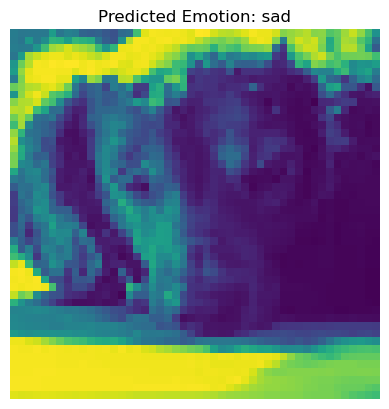

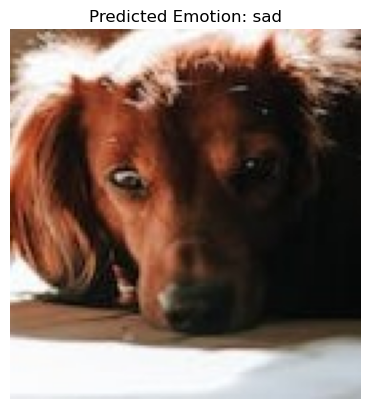

In [10]:
from keras.models import load_model
# Load the saved model
loaded_model = load_model("facial_expression_model.h5")



# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (48, 48))  # Resize to a fixed size for the model
            images.append(img)
    return images


# Load a custom test image
custom_test_image_path = "/kaggle/input/pets-facial-expression-dataset/Sad/4214919.jpg"

custom_test_image = cv2.imread(custom_test_image_path)
custom_test_image = cv2.cvtColor(custom_test_image, cv2.COLOR_BGR2GRAY)
custom_test_image = cv2.resize(custom_test_image, (48, 48))
custom_test_image = custom_test_image.astype('float32') / 255.0

# Reshape the image to match the model input shape
custom_test_image = np.expand_dims(custom_test_image, axis=0)
custom_test_image = np.expand_dims(custom_test_image, axis=-1)

# Make predictions on the custom test image
prediction = loaded_model.predict(custom_test_image)
prediction_prob = prediction[0]

emotion_label = np.argmax(prediction[0])

# Map the predicted label to emotion class
emotion_classes = {0: 'happy', 1: 'sad', 2: 'angry'}
predicted_emotion = emotion_classes[emotion_label]

# Print the custom test image and its predicted label
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence [happy, sad, angry]: {prediction_prob}")

import matplotlib.pyplot as plt

#Display the custom test image using matplotlib
plt.imshow(custom_test_image[0, :, :, 0])
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

from PIL import Image
# Display the original custom test image using PIL
img_pil = Image.open(custom_test_image_path)
plt.imshow(np.array(img_pil))
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

